<a href="https://www.kaggle.com/code/angelchaudhary/case-study-forecast-horizon-breakdown?scriptVersionId=290388739" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# How does forecast performance change as the prediction horizon increases, and why does strong short-term accuracy not guarantee long-term reliability?

# Introduction
Forecasting models are often evaluated on short horizons, where predictions look accurate and errors seem small. However, real-world decisions frequently depend on forecasts made weeks or months ahead where uncertainty compounds and reliability matters more than precision.

In this case study, we compare model performance across multiple forecast horizons: 1-step, 7-step, and 30-step ahead predictions using the same underlying data and model. Instead of focusing on a single accuracy number, we examine how errors grow and behave as the forecast horizon extends.

This is how we'll do it:
- Train a forecasting model on historical data
- Generate forecasts at different horizons
- Measure and visualize how errors evolve across time

## Approach
By breaking evaluation into multiple horizons, we highlight the non linear compounding of error and show why evaluating only one forecast step can be misleading. This horizon aware view provides a more realistic picture of model reliability in practical forecasting systems.


# LET'S DO IT!!!
![FUNNY GIF](https://gifdb.com/images/thumbnail/happy-cat-working-on-computer-cartoon-c2cinzv2rijwf3en.webp)

## Dataset 
We use a real-world monthly U.S. air traffic dataset (1999–2025). The presence of seasonality, long-term trends, and structural shocks makes it well-suited for analyzing how forecast reliability changes as the prediction horizon increases.

In [1]:
import kagglehub

path = kagglehub.dataset_download("nilesh2042/air-traffic-passenger-trends-usa-20052024")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/air-traffic-passenger-trends-usa-20052024


## Data Pre-Processing

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/air-traffic-passenger-trends-usa-20052024/Air_Traffic_Passenger_Statistics.csv")
df.head()

,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432,2025/06/20 01:00:30 PM,2025/07/20 03:02:25 PM
1,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353,2025/06/20 01:00:30 PM,2025/07/20 03:02:25 PM
2,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518,2025/06/20 01:00:30 PM,2025/07/20 03:02:25 PM
3,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,1324,2025/06/20 01:00:30 PM,2025/07/20 03:02:25 PM
4,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,1198,2025/06/20 01:00:30 PM,2025/07/20 03:02:25 PM


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38196 entries, 0 to 38195
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              38196 non-null  int64 
 1   Activity Period Start Date   38196 non-null  object
 2   Operating Airline            38196 non-null  object
 3   Operating Airline IATA Code  37880 non-null  object
 4   Published Airline            38196 non-null  object
 5   Published Airline IATA Code  37880 non-null  object
 6   GEO Summary                  38196 non-null  object
 7   GEO Region                   38196 non-null  object
 8   Activity Type Code           38196 non-null  object
 9   Price Category Code          38196 non-null  object
 10  Terminal                     38196 non-null  object
 11  Boarding Area                38196 non-null  object
 12  Passenger Count              38196 non-null  int64 
 13  data_as_of                   38

In [4]:
df.describe()


,Activity Period,Passenger Count
count,38196.000000,38196.000000
mean,201272.651875,27814.069798
std,758.197903,61982.220302
min,199907.000000,0.000000
25%,200609.000000,4355.750000
50%,201307.000000,8596.000000
75%,201907.000000,19675.750000
max,202505.000000,856501.000000


#### What we observed:
- the dataset contains a time indicator (`Activity Period`, `Activity Period Start Date`),
- passenger volume is recorded as a numeric target (`Passenger Count`),
- the same month appears multiple times due to categorical splits rather than missing data.

At this stage, the data does not yet represent a single time series suitable for forecasting. To analyze forecast behavior across different horizons, the data must first be aggregated into a unified monthly passenger time series. This aggregation step is intentional and allows us to focus on how forecast reliability changes with horizon length, rather than on airline or terminal-specific effects.

In [5]:
df['date'] = pd.to_datetime(df['Activity Period'].astype(str), format='%Y%m')


In [6]:
ts = (df.groupby('date')['Passenger Count'].sum().sort_index())

In [7]:
ts.head()
ts.tail()

date
2025-01-01    4025815
2025-02-01    3544840
2025-03-01    4276931
2025-04-01    4457148
2025-05-01    4861243
Name: Passenger Count, dtype: int64

In [8]:
ts.index.inferred_freq

'MS'

<Axes: title={'center': 'Total Monthly Air Traffic'}, xlabel='date'>

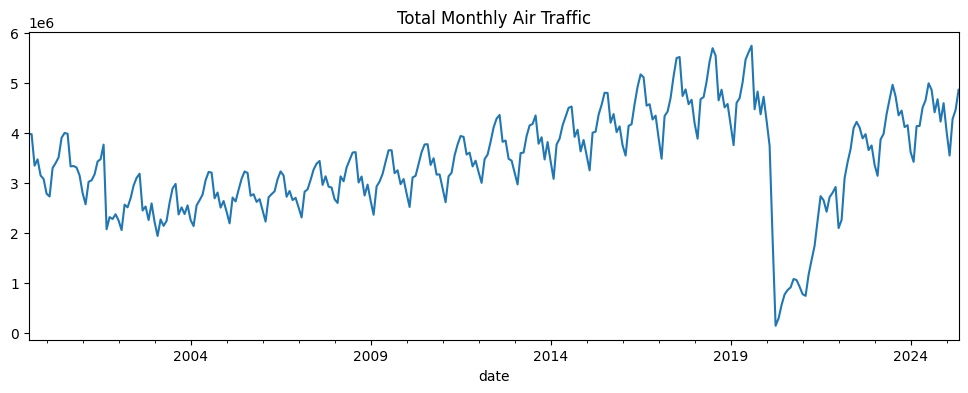

In [9]:
ts.plot(figsize=(12,4), title="Total Monthly Air Traffic")

#### Aggregated Monthly Time Series

After aggregation, the dataset is transformed into a single univariate time series representing the **total number of air passengers per month**. Each timestamp now corresponds to one calendar month, with passenger counts summed across all airlines, terminals, activity types, and regions.

The time series plot reveals several important characteristics. There is a clear long-term upward trend, accompanied by strong seasonal fluctuations that repeat annually. In addition, the series exhibits a sharp structural break around 2020, corresponding to a sudden collapse in air traffic, followed by a gradual recovery phase.

## Forecasting Task and Horizon Definition

With the data aggregated into a single monthly time series, we now define the forecasting task. The objective is not to maximize accuracy for a single prediction step but to understand how forecast reliability changes as the prediction horizon increases. In real-world systems, forecasts are often consumed at different horizons, yet evaluation is usually performed at only one.

To study this effect, we'll evaluate the same forecasting model across multiple horizons:
- **1-step ahead** (short-term)
- **7-step ahead** (medium-term)
- **30-step ahead** (long-term)

All forecasts are generated using a rolling (walk-forward) evaluation strategy. At each point in time, the model is trained only on past data, predictions are made `h` steps into the future and the window is advanced forward. This setup allows us to observe how prediction error compounds as the forecast horizon grows.

The key idea is simple:  
**a model that performs well at short horizons may still be unreliable at longer horizons.**


In [10]:
# Define forecast horizons
horizons = [1, 7, 30]

test_start_date = ts.index[-60]  # last 5 years (monthly)

train_ts = ts.loc[:test_start_date]
test_ts = ts.loc[test_start_date:]


In [11]:
def rolling_forecast(series, model_fn, horizon, start_index):
    """
    series: full time series
    model_fn: function that fits a model and returns forecasts
    horizon: number of steps ahead to forecast
    start_index: index position where rolling evaluation begins
    """
    forecasts = []
    actuals = []
    forecast_dates = []

    for i in range(start_index, len(series) - horizon):
        train_data = series.iloc[:i]
        test_data = series.iloc[i + horizon]

        pred = model_fn(train_data, horizon)

        forecasts.append(pred)
        actuals.append(test_data)
        forecast_dates.append(series.index[i + horizon])

    return forecast_dates, forecasts, actuals


## Baseline Model: Seasonal Naive Forecast

To isolate the effect of forecast horizon, we'll start with a simple baseline model rather than a complex machine learning approach. We'll use a **Seasonal Naive** forecasting strategy. For monthly data, this model predicts that future values will repeat the value observed one year earlier. Despite its simplicity, this baseline often performs surprisingly well on seasonal time series and provides a strong reference point for evaluation.

In [12]:
def seasonal_naive_model(train_series, horizon, season_length=12):
    """
    Seasonal naive forecast:
    predicts that future values repeat the value from one season ago.
    """
    return train_series.iloc[-season_length]


In [13]:
# Run Rolling Forecasts for Each Horizon
results = {}

start_index = ts.index.get_loc(test_start_date)

for h in horizons:
    dates, preds, actuals = rolling_forecast(
        series=ts,
        model_fn=seasonal_naive_model,
        horizon=h,
        start_index=start_index
    )
    
    results[h] = {"dates": dates,"predictions": preds,"actuals": actuals}


In [14]:
# computes error per horizon
from sklearn.metrics import mean_absolute_error

for h in horizons:
    mae = mean_absolute_error(
        results[h]["actuals"],
        results[h]["predictions"]
    )
    print(f"Horizon {h}-step MAE: {mae:,.0f}")


Horizon 1-step MAE: 1,435,900
Horizon 7-step MAE: 1,739,093
Horizon 30-step MAE: 2,345,474


### Horizon-wise Error Analysis

The Mean Absolute Error (MAE) increases steadily as the forecast horizon grows. Short-term (1-step) forecasts are the most accurate, while errors become noticeably larger at 7-step and degrade further at 30-step horizons. Since the same model and evaluation setup are used throughout, this increase in error is driven purely by the prediction horizon. This highlights a key takeaway of the case study:  **good short-term accuracy does not guarantee reliable long-term forecasts.**

Evaluating models at only one horizon can therefore give a misleading sense of performance.


## Forecasts vs Actuals Across Horizons

Numerical error metrics summarize performance, but they do not show *how* forecasts fail as the horizon increases. To make horizon effects tangible, we visualize predicted values against actual observations for each forecast horizon.

All plots below use the same baseline model and evaluation period. The only difference is how far into the future the forecast is made.


In [15]:
import matplotlib.pyplot as plt

def plot_forecast(results, horizon, n_points=60):
    dates = results[horizon]["dates"][-n_points:]
    preds = results[horizon]["predictions"][-n_points:]
    actuals = results[horizon]["actuals"][-n_points:]
    
    plt.figure(figsize=(12,4))
    plt.plot(dates, actuals, label="Actual")
    plt.plot(dates, preds, label="Forecast")
    plt.title(f"{horizon}-Step Ahead Forecast")
    plt.legend()
    plt.show()


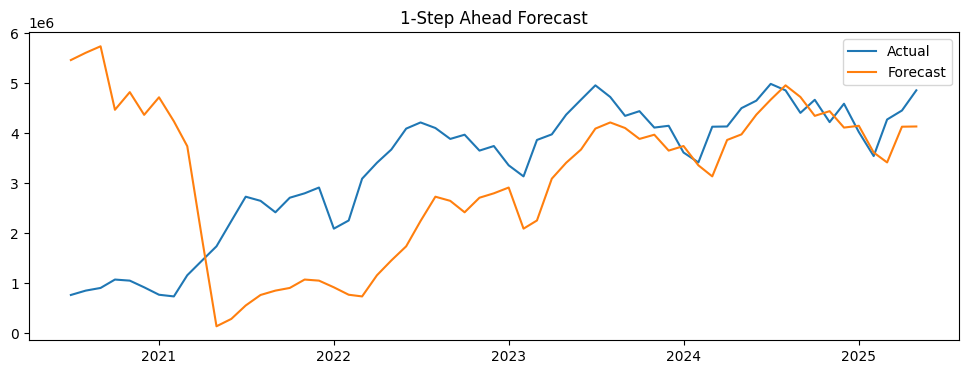

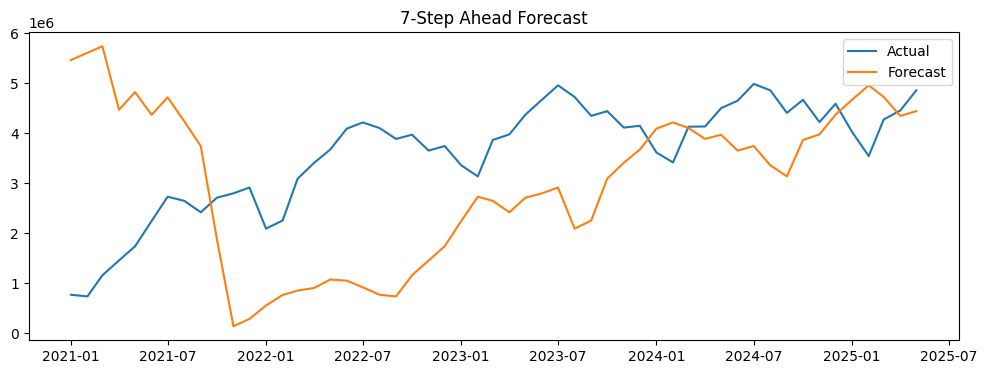

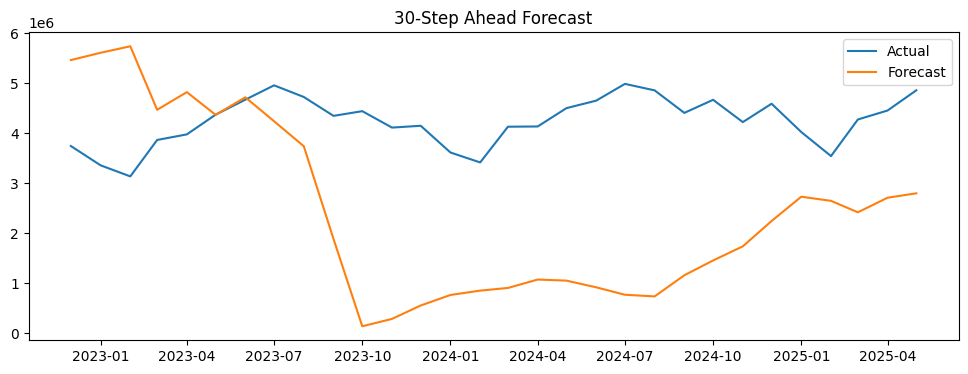

In [16]:
# visualize each horizon
plot_forecast(results, horizon=1)
plot_forecast(results, horizon=7)
plot_forecast(results, horizon=30)


### Interpretation

At the **1-step horizon**, forecasts closely follow the actual series. Short-term trends and seasonal movements are captured reasonably well, with relatively small and temporary deviations.

At the **7-step horizon**, forecast quality visibly degrades. While the overall direction is still somewhat aligned, the timing and magnitude of seasonal peaks and troughs begin to drift, leading to larger and more persistent errors.

At the **30-step horizon**, the forecasts diverge substantially from reality. Small errors in trend and seasonality estimation compound over time, resulting in large gaps between predicted and actual values. The model struggles to recover once it drifts off course.

Together, these plots highlight the core insight of this case study:  
**forecast error grows non-linearly with horizon length, and strong short-term performance does not translate into long-term reliability.**


## Conclusion

This case study shows that forecast performance depends not just on the model, but critically on the prediction horizon. Using the same data, model, and evaluation setup, we observed that errors increase and forecasts become less reliable as the horizon extends. Short term accuracy can therefore be misleading when models are used for longer-term decisions. By explicitly evaluating multiple horizons, we gain a more realistic understanding of forecast behavior and avoid overconfidence in systems that appear accurate in the short run but fail under longer-term uncertainty.